In [1]:
#! pip install nibabel -U

In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd

import surface_distance_based_measures

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
task_number = "05"
task_name = "prostate".lower()
path = "./Task%s_%s/3d_fullres" % (task_number, task_name.capitalize())
file_prefix = task_name

labels = [1, 2]

run_data = [
    "A100/22972351",
    "A100/23011851",
    "A100/23012378",
]

validation_raw_numbers = [
    "00",
    "04",
    "14",
    "20",
    "25",
    "31",
    "42",
]

results = []

In [5]:
# Calculate DSC: Dice Similarity Coefficient; NSD: Normalized Surface Distance
for run in run_data:

    run_info = {}
    run_info[run] = {}

    for validation_raw_number in validation_raw_numbers:

        run_info[run][validation_raw_number] = {}

        # Ground Truth
        mask_gt_img = nib.load(
            "./Task%s_%s/ground_truth/labelsTr/%s_%s.nii.gz"
            % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
        )
        mask_gt = np.array(mask_gt_img.dataobj)

        # Run data
        mask_pred_img = nib.load(
            "%s/%s/results/fold_0/validation_raw_postprocessed/%s_%s.nii.gz"
            % (path, run, file_prefix, validation_raw_number)
        )
        mask_pred = np.array(mask_pred_img.dataobj)

        # Calculate the DSC and the NSD for each label separately
        for label in labels:

            run_info[run][validation_raw_number][label] = {}

            # Only include the values that match the label number
            label_mask_gt = (mask_gt == label).astype(int)
            label_mask_pred = (mask_pred == label).astype(int)

            # Calculate Dice Score
            run_info[run][validation_raw_number][label][
                "dice_similarity_coefficient"
            ] = surface_distance_based_measures.compute_dice_coefficient(
                label_mask_gt, label_mask_pred
            )

            # Calculate Normalized Surface Distance
            spacing_mm = (3, 2, 1)
            surface_distances = (
                surface_distance_based_measures.compute_surface_distances(
                    label_mask_gt, label_mask_pred, spacing_mm
                )
            )
            run_info[run][validation_raw_number][label][
                "normalized_surface_distance"
            ] = surface_distance_based_measures.compute_surface_dice_at_tolerance(
                surface_distances, 1
            )

    results.append(run_info)

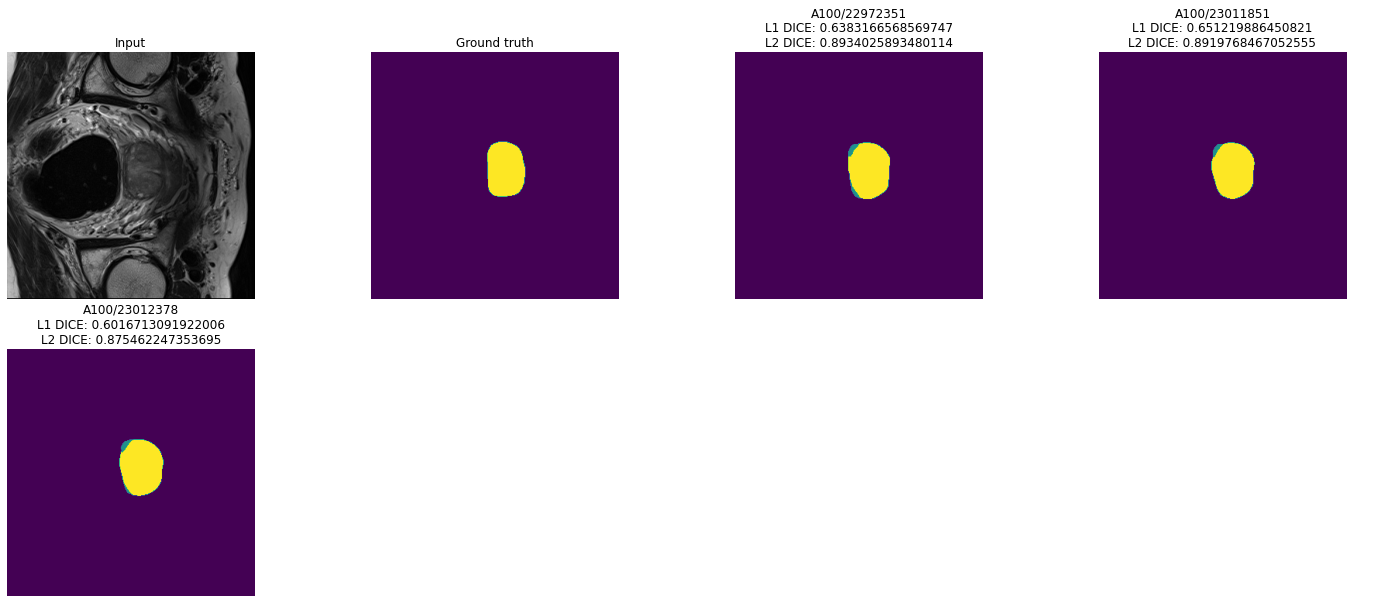

In [6]:
validation_raw_number = "00"
display_layer = 10

# Calculate the number of rows based on the size of results + 2 (input & ground truth)
# and the value of n_cols
n_cols = 4
n_rows = int(np.ceil((len(results) + 2) / n_cols))

# Define the number of rows and columns and set the graph size
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, n_rows * 5))

# Hide the graph axes
for ax in axes.flatten():
    ax.axis("off")

# Display the input image as the first image
axes[0, 0].imshow(
    nib.load(
        "./Task%s_%s/ground_truth/imagesTr/%s_%s.nii.gz"
        % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
    ).get_fdata()[:, :, display_layer, 0],
    cmap="gray",
)
axes[0, 0].set_title("Input")

# Display the ground truth as the second image
axes[0, 1].imshow(
    nib.load(
        "./Task%s_%s/ground_truth/labelsTr/%s_%s.nii.gz"
        % (task_number, task_name.capitalize(), file_prefix, validation_raw_number)
    ).get_fdata()[:, :, display_layer]
)
axes[0, 1].set_title("Ground truth")


for i, result in enumerate(results):

    # The first key should the run name (ie A100/12345678)
    run = list(result.keys())[0]

    image_path = (
        "%s/%s/results/fold_0/validation_raw_postprocessed/%s_%s.nii.gz"
        % (path, run, file_prefix, validation_raw_number)
    )

    # Use i + 2 instead of i because of the input image and the ground truth always being the first 2 images

    # Calculate the row number by dividing the list item number by the number of columns and rounding down
    row = int(np.floor((i + 2) / n_cols))
    # Calculate the column number by finding the remainder of the list item number divided by the number of columns
    column = int(np.remainder((i + 2), n_cols))

    # Display the display_layer layer of the image
    axes[row, column].imshow(nib.load(image_path).get_fdata()[:, :, display_layer])

    # Set the title the run name and DICE score for each label
    title = "%s" % run
    for label in labels:
        title = "%s\nL%s DICE: %s" % (
            title,
            label,
            result[run][validation_raw_number][label]["dice_similarity_coefficient"],
        )
    axes[row, column].set_title(title)

### Create a list of dataframes for each label with the dice similarity coefficient & normalized surface distance scores

In [7]:
def create_scores_dataframes(score_name):
    scores = []

    # Add a new dataframe to the list for each label
    for label in labels:

        # Create a new dataframe for the label
        label_scores = pd.DataFrame(index=validation_raw_numbers, columns=run_data)

        # Loop through the results
        for result in results:

            # Get the name of the run
            run = list(result.keys())[0]

            # Add the results of the run to the dataframe as a column
            for validation_raw_number in list(result[run].keys()):
                label_scores[run][validation_raw_number] = result[run][
                    validation_raw_number
                ][label][score_name]

        # Add the label scores to the scores list
        scores.append(label_scores)

    return scores

In [8]:
dice_similarity_coefficient_scores = create_scores_dataframes(
    "dice_similarity_coefficient"
)
normalized_surface_distance_scores = create_scores_dataframes(
    "normalized_surface_distance"
)

for idx, label in enumerate(labels):
    print("Label %s:" % label)
    print("Dice Similarity Coefficient:")
    display(dice_similarity_coefficient_scores[idx].head())
    print("Normalized Surface Distance:")
    display(normalized_surface_distance_scores[idx].head())

Label 1:
Dice Similarity Coefficient:


,A100/22972351,A100/23011851,A100/23012378
00,0.638317,0.65122,0.601671
04,0.728075,0.724305,0.725526
14,0.779113,0.780541,0.774873
20,0.789432,0.793674,0.783798
25,0.719433,0.730707,0.728876


Normalized Surface Distance:


,A100/22972351,A100/23011851,A100/23012378
00,0.746432,0.774219,0.706872
04,0.762176,0.777441,0.762533
14,0.879521,0.886024,0.881359
20,0.824082,0.854015,0.86332
25,0.781369,0.787815,0.798822


Label 2:
Dice Similarity Coefficient:


,A100/22972351,A100/23011851,A100/23012378
00,0.893403,0.891977,0.875462
04,0.885207,0.887898,0.886297
14,0.871447,0.869541,0.862245
20,0.91838,0.917418,0.914792
25,0.907576,0.90792,0.911133


Normalized Surface Distance:


,A100/22972351,A100/23011851,A100/23012378
00,0.878889,0.883747,0.837471
04,0.762847,0.76447,0.765774
14,0.843121,0.851499,0.840347
20,0.889259,0.883346,0.881783
25,0.814858,0.838458,0.841145


### Print the mean dice similarity coefficient and normalized surface distance scores for each label

In [9]:
for idx, label in enumerate(labels):
    print("Label %s:" % label)
    print("Dice Similarity Coefficient:")
    print(dice_similarity_coefficient_scores[idx].mean(axis=0))
    print("Normalized Surface Distance:")
    print(normalized_surface_distance_scores[idx].mean(axis=0))
    print()

Label 1:
Dice Similarity Coefficient:
A100/22972351    0.727282
A100/23011851    0.724927
A100/23012378    0.717262
dtype: float64
Normalized Surface Distance:
A100/22972351    0.784404
A100/23011851    0.790021
A100/23012378    0.784848
dtype: float64

Label 2:
Dice Similarity Coefficient:
A100/22972351    0.895173
A100/23011851    0.895688
A100/23012378    0.891132
dtype: float64
Normalized Surface Distance:
A100/22972351    0.833970
A100/23011851    0.840399
A100/23012378    0.831182
dtype: float64

